In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pprint import pprint
from copy import copy
import time
import warnings
from itertools import cycle, islice
import sys

from astropy.stats import gaussian_sigma_to_fwhm
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.nddata import Cutout2D
from astropy.table import Table, hstack, vstack, unique
from astropy.wcs import wcs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as uu
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar, colors
from matplotlib.colors import LogNorm
import matplotlib.markers as mmarkers
import matplotlib.font_manager as fm
from matplotlib import gridspec
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.offsetbox
from matplotlib.lines import Line2D
import numpy as np
from loguru import logger
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from vasca.field import BaseField, GALEXField
from vasca.utils import extr_value, table_to_array, get_hist_bins

# Setup

In [3]:
pd.set_option('display.max_columns', 60)
plt.style.use("/Volumes/Macintosh HD/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/final_sensors/uc-aspectdatanalysis/uc_asproc/mpl_style_sheets/spie_scout_testing.mplstyle")

def jl_fig(num, **kwargs):
    plt.close(num)
    fig, ax = plt.subplots(num=num, **kwargs)
    return (fig, ax)

In [4]:
# replacing the standard handler
try:
    logger.remove(0)
except ValueError:
    print("[Loguru]: Default handler already removed.")

# setup custom handler to make use of
# additional fields defined by vasca
fmt = (
    "<g>{time:YYYY-MM-DD HH:mm:ss.SSS}</> | "
    "<lvl>{level: ^8}</> | "
    "<c>{name}</>:<c>{line}</> in <c>{extra[classname]}</>:<c>{function}</> | "
    "<lvl>{message}</>"
)
logger.add(sys.stdout, format=fmt, backtrace=False, level="DEBUG")
# activate logging (is deactivated by import of vasca)
logger.enable("vasca")

In [5]:
# load field
"""
list of fields
2552663716076191744 NGS 32 visits
2424979629631602688 MIS 5 visits
2508155485249601536 DIS 5 visits
6388191295067652096 NGC4993-GW170817 2 visits
6381787756527353856 AIS_309_1_28 2 visits (Crab pulsar)

TDS fields
2605053246158405632 PS_COSMOS_MOS23 DIS 29 visits 
2593653509626789888 PS_CDFS_MOS00 DIS 114 visits 
2594075722091855872 PS_CDFS_MOS06 DIS 29 visits 
2607375414741434368 PS_GROTH_MOS06 DIS 18 visits 
"""

# filed ID
field_id = 6388191295067652096

# initialize field analysis
from_archive = True
from_fits = False

if from_archive:
    gf = GALEXField.from_MAST(obs_id=field_id, obs_filter="NUV", refresh=False)
    fits_path = f"{gf.data_path}/{gf.vasca_file_prefix}_field_data.fits"
    gf.write_to_fits(fits_path)
elif from_fits:
    gf = GALEXField.from_VASCA(obs_id=field_id, obs_filter="NUV")



2022-05-02 17:39:23.256 |  DEBUG   | vasca.field:734 in GALEXField:__init__ | Field data path set to: '/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_fields/6388191295067652096'
2022-05-02 17:39:23.257 |  DEBUG   | vasca.field:735 in GALEXField:__init__ | Visits data path set to: '/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_visits_list/GALEX_visits_list.fits'
2022-05-02 17:39:23.258 |  DEBUG   | vasca.field:920 in GALEXField:_load_galex_field_info | Reading archive field info from cashed file '/Users/julianschliwinski/Library/Mobile Documents/com~apple~CloudDocs/PhD/ULTRASAT/Science/cloud/uc_science/uvvarcat/GALEX_fields/6388191295067652096/MAST_6388191295067652096_NUV_coadd.fits'
2022-05-02 17:39:23.287 |  DEBUG   | vasca.field:926 in GALEXField:_load_galex_field_info | Constructing 'tt_field'.
2022-05-02 17:39:23.289 |  DEBUG   | v

In [6]:
print(gf.n_visits)
print(gf.name)

2
AIS_491_1_12


# First clustering attempt

In [7]:
# cluster settings
r_cluster = (5.0 * uu.arcsec).to(uu.degree).value  # in deg
r_fov = 0.55  # in deg
params = {
    "bandwidth": r_cluster,
    "bin_seeding": False,
    #"min_bin_freq": 10,
    "cluster_all": True,
    "n_jobs": 4,
}
# VASCA clustering
gf.cluster_meanshift(ms_kw=params)

2022-05-02 17:39:27.616 |   INFO   | vasca.field:383 in GALEXField:cluster_meanshift | Clustering sources}
2022-05-02 17:39:27.618 |  DEBUG   | vasca.field:389 in GALEXField:cluster_meanshift | MeanShift with parameters '{'bandwidth': 0.001388888888888889, 'bin_seeding': False, 'cluster_all': True, 'max_iter': 300, 'min_bin_freq': 1, 'n_jobs': 4, 'seeds': None}'
2022-05-02 17:39:43.366 |  DEBUG   | vasca.tables:435 in GALEXField:add_table | Adding table 'base_field:tt_sources'
2022-05-02 17:39:43.369 |  DEBUG   | vasca.tables:415 in GALEXField:table_from_template | Created new table from template 'base_field:tt_sources'.
2022-05-02 17:39:43.370 |  DEBUG   | vasca.field:499 in GALEXField:remove_double_visit_detections | Scanning for doubled visit detections
2022-05-02 17:39:46.166 | WARNING  | vasca.field:530 in GALEXField:remove_double_visit_detections | Removed Nr. double visit detections:16
2022-05-02 17:39:48.888 |   INFO   | vasca.field:458 in GALEXField:add_light_curve | Creating 

6386

In [8]:
gf.tt_sources

src_id,ra,dec,nr_det,flag,sel
,deg,deg,,,
uint32,float32,float32,uint32,int32,uint8
2,198.43707,-23.044176,3,0,1
2,198.16953,-23.163288,3,0,1
...,...,...,...,...,...
1,197.15834,-23.05419,1,0,1
1,197.1583,-23.037096,1,0,1


In [9]:
gf.tt_detections

vis_id,src_id,det_id,ra,dec,pos_err,mag,mag_err,r_fov,artifacts,point_src_prob,bright_match,flux_f60,flux_f60_err,flux_f38,flux_f38_err,E_bv,sel
,,,deg,deg,deg,,,deg,,,,,,,,,
uint64,int64,uint64,float64,float64,float64,float32,float32,float32,int32,float32,int32,float64,float64,float64,float64,float64,uint8
6388191157628698624,507,6388191157629747201,197.82335469959443,-23.589975434093283,0.00013316271360963583,14.848554,0.013272484,0.5788923,0,0.7838721,0,75.86798858642578,1.2661969661712646,41.49015426635742,1.0061039924621582,0.12803974747657776,1
6388191157628698624,3828,6388191157629747202,197.8005890532701,-23.613203256866104,0.00038684936589561403,22.008749,0.8149606,0.6020103,33,0.71674925,0,0.23758745193481445,0.16445401310920715,0.21659864485263824,0.12991467118263245,0.13039766252040863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388191157662253056,4619,6388191157664354421,197.63519861601483,-22.498804033281314,-0.2775000035762787,-999.0,-999.0,0.52922714,0,0.0,0,-99.0,-99.0,-99.0,-99.0,0.11554595082998276,1
6388191157662253056,3078,6388191157664354422,197.9287748610005,-22.451882581273836,-0.2775000035762787,-999.0,-999.0,0.55962205,0,0.0,0,-99.0,-99.0,-99.0,-99.0,0.12047320604324341,1


In [10]:
display(np.unique(gf.tt_sources["src_id"]))
display(np.unique(gf.tt_detections["src_id"]))
assert len(np.unique(gf.tt_detections["src_id"])) == len(np.unique(gf.tt_sources["src_id"])), "Inoncsitent data."

1
2


0
1
2
3
4
...
6382
6383
6384
6385


AssertionError: Inoncsitent data.

# Second clustering attempt

In [11]:
# VASCA clustering
gf.cluster_meanshift(ms_kw=params)

2022-05-02 17:41:02.006 |   INFO   | vasca.field:383 in GALEXField:cluster_meanshift | Clustering sources}
2022-05-02 17:41:02.008 |  DEBUG   | vasca.field:389 in GALEXField:cluster_meanshift | MeanShift with parameters '{'bandwidth': 0.001388888888888889, 'bin_seeding': False, 'cluster_all': True, 'max_iter': 300, 'min_bin_freq': 1, 'n_jobs': 4, 'seeds': None}'
2022-05-02 17:41:16.280 |  DEBUG   | vasca.tables:435 in GALEXField:add_table | Adding table 'base_field:tt_sources'
2022-05-02 17:41:16.281 | WARNING  | vasca.tables:440 in GALEXField:add_table | Table 'tt_sources' already exists, overwriting
2022-05-02 17:41:16.283 |  DEBUG   | vasca.tables:415 in GALEXField:table_from_template | Created new table from template 'base_field:tt_sources'.
2022-05-02 17:41:16.284 |  DEBUG   | vasca.field:499 in GALEXField:remove_double_visit_detections | Scanning for doubled visit detections
2022-05-02 17:41:19.141 |   INFO   | vasca.field:458 in GALEXField:add_light_curve | Creating light curve 

6386

In [12]:
gf.tt_sources

src_id,ra,dec,nr_det,flag,sel
,deg,deg,,,
uint32,float32,float32,uint32,int32,uint8
0,198.45877,-23.006039,2,0,1
1,198.4536,-23.050674,2,0,1
...,...,...,...,...,...
6384,197.15834,-23.05419,1,0,1
6385,197.1583,-23.037096,1,0,1


In [13]:
gf.tt_detections

vis_id,src_id,det_id,ra,dec,pos_err,mag,mag_err,r_fov,artifacts,point_src_prob,bright_match,flux_f60,flux_f60_err,flux_f38,flux_f38_err,E_bv,sel
,,,deg,deg,deg,,,deg,,,,,,,,,
uint64,int64,uint64,float64,float64,float64,float32,float32,float32,int32,float32,int32,float64,float64,float64,float64,float64,uint8
6388191157628698624,496,6388191157629747201,197.82335469959443,-23.589975434093283,0.00013316271360963583,14.848554,0.013272484,0.5788923,0,0.7838721,0,75.86798858642578,1.2661969661712646,41.49015426635742,1.0061039924621582,0.12803974747657776,1
6388191157628698624,3825,6388191157629747202,197.8005890532701,-23.613203256866104,0.00038684936589561403,22.008749,0.8149606,0.6020103,33,0.71674925,0,0.23758745193481445,0.16445401310920715,0.21659864485263824,0.12991467118263245,0.13039766252040863,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388191157662253056,4617,6388191157664354421,197.63519861601483,-22.498804033281314,-0.2775000035762787,-999.0,-999.0,0.52922714,0,0.0,0,-99.0,-99.0,-99.0,-99.0,0.11554595082998276,1
6388191157662253056,3073,6388191157664354422,197.9287748610005,-22.451882581273836,-0.2775000035762787,-999.0,-999.0,0.55962205,0,0.0,0,-99.0,-99.0,-99.0,-99.0,0.12047320604324341,1


In [14]:
display(np.unique(gf.tt_sources["src_id"]))
display(np.unique(gf.tt_detections["src_id"]))
assert len(np.unique(gf.tt_detections["src_id"])) == len(np.unique(gf.tt_sources["src_id"])), "Inoncsitent data."

0
1
2
3
4
...
6382
6383
6384
6385


0
1
2
3
4
...
6382
6383
6384
6385


In [10]:
def mscatter(x, y, ax=None, m=None, **kw):
    """
    Wrapper for matplotlib.pyplot.scatter() that allows marker to be a list.
    From https://stackoverflow.com/a/52303895/13115938
    """
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def draw_sizebar(ax, length, label, loc="lower right", fontsize=10, frameon=False, label_top=False):
    """
    Draw a horizontal bar with given length in data coordinates,
    with a label underneath.
    """
    fontprops = fm.FontProperties(size=fontsize)
    asb = AnchoredSizeBar(
        ax.transData,
        #ax.get_transform('fk5'),
        length,
        label,
        loc=loc,
        pad=0.1, borderpad=0.8, sep=5,
        frameon=frameon,
        label_top=label_top,
        fontproperties=fontprops,
    )
    ax.add_artist(asb)

In [9]:
def show_cluster(data, cluster_obj, ax=None, num=99, scale_bar=True, comp_time=None, normalize=False):
    
    X = data
    labels = cluster_obj.labels_

    # ============
    # Plot
    # ============
    if ax is None:
        fig, ax = jl_fig(num=num, figsize=(6,6), constrained_layout=True)
        # fig.suptitle("")

    #color cycler
    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(labels) + 1),
            )
        )
    )
    colors = np.append(colors, ["#000000"]) # black for outliers (if any)
    
    # marker cycler
    markers = np.array(
        list(
            islice(
                cycle(
                    [    
                        "s",
                        "v",
                        "^",
                        "h",
                        "+",
                        "p",
                        "*",
                        "<",
                        ">",
                        ".",
                    ]
                ),
                int(max(labels) + 1),
            )
        )
    )
    markers = np.append(markers, ["x"]) # x for outliers (if any)
    
    # draw
    mscatter(X[:, 0], X[:, 1], ax=ax, s=3**2, c=colors[labels], m=markers[labels], alpha=0.2)
    
    ax.invert_xaxis()
    
    # draw scale bar
    if scale_bar:
        r_cluster_arcsec = (cluster_obj.get_params()["bandwidth"]*uu.deg).to(uu.arcsec)
        draw_sizebar(ax, r_cluster, f"{r_cluster_arcsec:1.1f}", loc="upper left", fontsize=8, frameon=False, label_top=True)
    
    # normalize
    if normalize:
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_xticks(())
        ax.set_yticks(())
    
    # add computation time info
    if comp_time is not None:
        ax.text(
            0.99,
            0.01,
            ("%.2fs" % comp_time).lstrip("0"),
            transform=plt.gca().transAxes,
            size=8,
            horizontalalignment="right",
        )

In [10]:
def cluster_meanshift(data, cluster_params, normalize=False, timeit=False):
    # ============
    # Setup
    # ============

    # update parameters with dataset-specific values
    default_params = {
        "quantile": 0.3,
        "bandwidth": None,
        "seeds": None,
        "bin_seeding": False,
        "min_bin_freq": 1,
        "cluster_all": True,
        "n_jobs": None,
        "max_iter": 300,
    }
    params = default_params.copy()
    params.update(cluster_params)

    # (x,y) data
    X = data

    # normalize dataset for easier parameter selection
    if normalize:
        X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    if params["bandwidth"] is None:
        bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    else:
        bandwidth = params["bandwidth"]

    # ============
    # Create cluster object
    # ============
    ms = cluster.MeanShift(
        bandwidth=bandwidth,
        seeds=params["seeds"],
        bin_seeding=params["bin_seeding"],
        min_bin_freq=params["min_bin_freq"],
        cluster_all=params["cluster_all"],
        n_jobs=params["n_jobs"],
        max_iter=params["max_iter"],
    )
    
    # ============
    # Compute cluster
    # ============
    t0 = time.time()

    ms.fit(X)

    t1 = time.time()
    comp_time = t1 - t0
    
    if timeit:
        return (ms, comp_time)
    else:
        return ms

In [11]:
coords = table_to_array(gf.tt_detections["ra", "dec"])

In [12]:
%%time
ms = cluster.MeanShift(bandwidth=r_cluster, bin_seeding=True, cluster_all=True, n_jobs=4)
ms.fit(coords)

print(f"n_label: {len(np.unique(ms.labels_))}")
print(f"n_cluster: {len(ms.cluster_centers_)}")

n_label: 42249
n_cluster: 42251
CPU times: user 1min 34s, sys: 29.4 s, total: 2min 3s
Wall time: 2min 39s


In [25]:
labels_alt = ms.predict(coords)

In [13]:
mms, comp_time = cluster_meanshift(coords, params, timeit=True)
print(f"n_label: {len(np.unique(mms.labels_))}")
print(f"n_cluster: {len(mms.cluster_centers_)}")
print(comp_time)

n_label: 44331
n_cluster: 44331
191.70295929908752


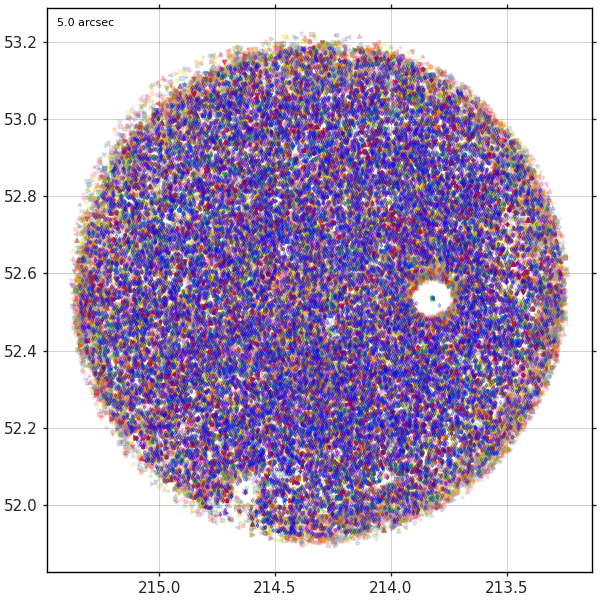

In [14]:
show_cluster(coords, ms)
ax = plt.gca()
ax.scatter(
    gf.tt_ref_sources["ra"],
    gf.tt_ref_sources["dec"],
    s=2**2,
    edgecolor=(0,0,1,0.5),
    facecolor=(0,0,1,0.1),
    lw=0.5,
    marker="d",
    zorder=1,
)

In [15]:
def get_sky_bounds(cutout, data_shape, out_frame="fk5"):
    """
    Returns SkyCoord object with coordinates for upperight and lower left
    pixels in coordinate system of 'out_frame'.
    """
    # corner pixels
    # lower left
    x_ll = 0
    y_ll = 0
    # upper right
    x_ur = data_shape[1]
    y_ur = data_shape[0]
    # convert to world coordinates
    ll = cutout.wcs.pixel_to_world(x_ll, y_ll)
    ur = cutout.wcs.pixel_to_world(x_ur, y_ur)
    # separtion
    #print(ll.separation(ur).deg)
          
    return  SkyCoord([ll.ra, ur.ra], [ll.dec, ur.dec], frame=ll.frame).transform_to(out_frame)


def get_cutout_mask(tt_mcat, cutout_bounds, frame="fk5"):
    """
    Returns a bool array to mask a dataset for a given cutout bounds.
    """
    x, y = None, None
    if frame=="icrs" or frame=="fk5":
        x = "ra"
        y = "dec"
        mask_cutout_ra = (tt_mcat[x]<=cutout_bounds[0].ra)  * (tt_mcat[x]>=cutout_bounds[1].ra)
        mask_cutout_dec = (tt_mcat[y]>=cutout_bounds[0].dec)  * (tt_mcat[y]<=cutout_bounds[1].dec)
    elif frame=="galctic":
        x = "lon"
        y = "lat"
        mask_cutout_ra = (tt_mcat[x]<=cutout_bounds[0].l)  * (tt_mcat[x]>=cutout_bounds[1].l)
        mask_cutout_dec = (tt_mcat[y]>=cutout_bounds[0].b)  * (tt_mcat[y]<=cutout_bounds[1].b)
    
    return mask_cutout_ra * mask_cutout_dec

In [16]:
src_ids, det_cts = np.unique(ms.labels_, return_counts=True)
# cluster indeces with n_sources > n_visits
cidxs = src_ids[det_cts>gf.n_visits]
print("Number of visits: ", gf.n_visits)
print("Number of sources:", det_cts[det_cts>5])
print("Cluster index:    ", cidxs)

# histogram number of sources per cluster
fig, ax = jl_fig(num=2, tight_layout=True)
fig.suptitle("Number of sources per cluster")
ax.set_ylabel("Number of clusters")
ax.set_xlabel("Number of sources")
bins = get_hist_bins(det_cts, bin_size=1)
bins = np.insert(bins, 6, 7)-0.5
_ = ax.hist(det_cts, bins=bins, log=True)
ax.vlines(x=gf.n_visits, ymin=0.01, ymax=1e+5, color="r", label="$N_{{visits}}$")
ax.set_ylim((1e+1,1e+4*2))
ax.legend()

Number of visits:  18
Number of sources: [18 18 18 ...  6  6  6]
Cluster index:     [  63  470  707  886 1027 1259 1633 1753 1873 2514 2560 2601 2771 3386
 3779 4087]


In [17]:
c = 1350  # cluster index
lidxs = np.where(ms.labels_ == c)[0]  # label/detection indeces corresponding to cluster
print(lidxs)
display(gf.tt_detections["ra", "dec"][lidxs])
print(ms.cluster_centers_[c,:])


[  6553  15718  25126  33984  43831  52831  61092  69127  78132  86764
  95612 104038 112478 120558 128953 135692 144363 153773]


ra,dec
deg,deg
float64,float64
213.9789567276941,52.77467886178793
213.97911030479193,52.77469982608067
213.97979918429823,52.77480502155232
...,...
213.97889792526874,52.77468488495648
213.9794425691521,52.77464421230757
213.97918895304488,52.77488117372847


[213.97917639  52.77470145]


In [18]:
def get_cluster_cutout(c, bounds=False):
    cpos = SkyCoord(ra=ms.cluster_centers_[c,0], dec=ms.cluster_centers_[c,1], frame="fk5", unit=uu.degree)

    set_cutout = {
                "position": cpos,
                "size": uu.Quantity((30, 30), uu.arcsec).to(uu.deg),
                "wcs": gf.ref_wcs
            }
    cutout = Cutout2D(gf.ref_img, **set_cutout)
    if bounds:
        cutout_bounds = get_sky_bounds(cutout, cutout.data.shape)
        return (cutout, cutout_bounds)
    else:
        return cutout


def draw_cluster(c, fig=None, nrows=1, ncols=1, sub_pos=1):

    # get cutout
    cutout, cutout_bounds = get_cluster_cutout(c, bounds=True)
    
    if fig is None:
        fig, ax = jl_fig(num=3, subplot_kw=dict(projection=cutout.wcs), tight_layout=True)
    else:
        ax = fig.add_subplot(nrows, ncols, sub_pos, projection=cutout.wcs)

    # cutout
    ax.imshow(cutout.data, cmap="Greys")

    # cluster center
    ax.scatter(
        ms.cluster_centers_[c,0],
        ms.cluster_centers_[c,1],
        transform=ax.get_transform("world"),
        s=7**2,
        edgecolor="b",
        facecolor="none",
        lw=1.5,
        marker="*",
        #alpha=0.5,
        label="cluster center",
        zorder=5
    )

    # cluster sources
    lidxs = np.where(ms.labels_ == c)[0]  # label/detection indeces corresponding to cluster
    pos_cluster_sources = SkyCoord.guess_from_table(gf.tt_detections["ra", "dec"][lidxs], frame="fk5")
    for i, src in enumerate(pos_cluster_sources):
        ax.scatter(
            src.ra,
            src.dec,
            transform=ax.get_transform("world"),
            s=5**2,
            edgecolor="r",
            facecolor="none",
            lw=1.5,
            marker="d",
            #alpha=0.5,
            label="clustered detections" if i == 0 else "_",
            zorder=4
        )

    # visit-level detections
    pos_detections = SkyCoord.guess_from_table(
        gf.tt_detections["ra","dec"][get_cutout_mask(gf.tt_detections, cutout_bounds, frame="fk5")]
    )

    for i, src in enumerate(pos_detections):
        ax.scatter(
            src.ra,
            src.dec,
            transform=ax.get_transform("world"),
            s=5**2,
            edgecolor="c",
            facecolor="none",
            lw=1.5,
            marker="d",
            #alpha=0.5,
            label="detections" if i == 0 else "_",
            zorder=3
        )
        ax.set_autoscale_on(False)

    # reference (coadded) sources
    pos_ref_sources = SkyCoord.guess_from_table(
        gf.tt_ref_sources["ra","dec"][get_cutout_mask(gf.tt_ref_sources, cutout_bounds, frame="fk5")]
    )

    for i, src in enumerate(pos_ref_sources):
        ax.scatter(
            src.ra,
            src.dec,
            transform=ax.get_transform("world"),
            s=5**2,
            edgecolor="g",
            facecolor="none",
            lw=1.5,
            marker="s",
            #alpha=0.5,
            label="ref. sources" if i == 0 else "_",
            zorder=3
        )

    label_fontsize=10

    #ax.legend(fontsize=label_fontsize)

    # modify grid
    ax.coords.grid(True, color='k', ls='-')

    # set axis labels
    ra = ax.coords["ra"]
    dec = ax.coords["dec"]
    ra.set_major_formatter("d.dd")
    dec.set_major_formatter("d.dd")


    ax.set_xlabel("Ra", fontsize=label_fontsize)
    ax.set_ylabel("Dec", fontsize=label_fontsize)
    ax.xaxis.set_tick_params(labelsize=label_fontsize)
    ax.yaxis.set_tick_params(labelsize=label_fontsize)
    ax.tick_params(axis="x", labelsize=label_fontsize, bottom=True, top=False)
    ax.tick_params(axis="y", labelsize=label_fontsize, left=True, right=False)
    
    axra = ax.coords[0]
    axdec = ax.coords[1]
    
    del cutout
    
    return ax

4


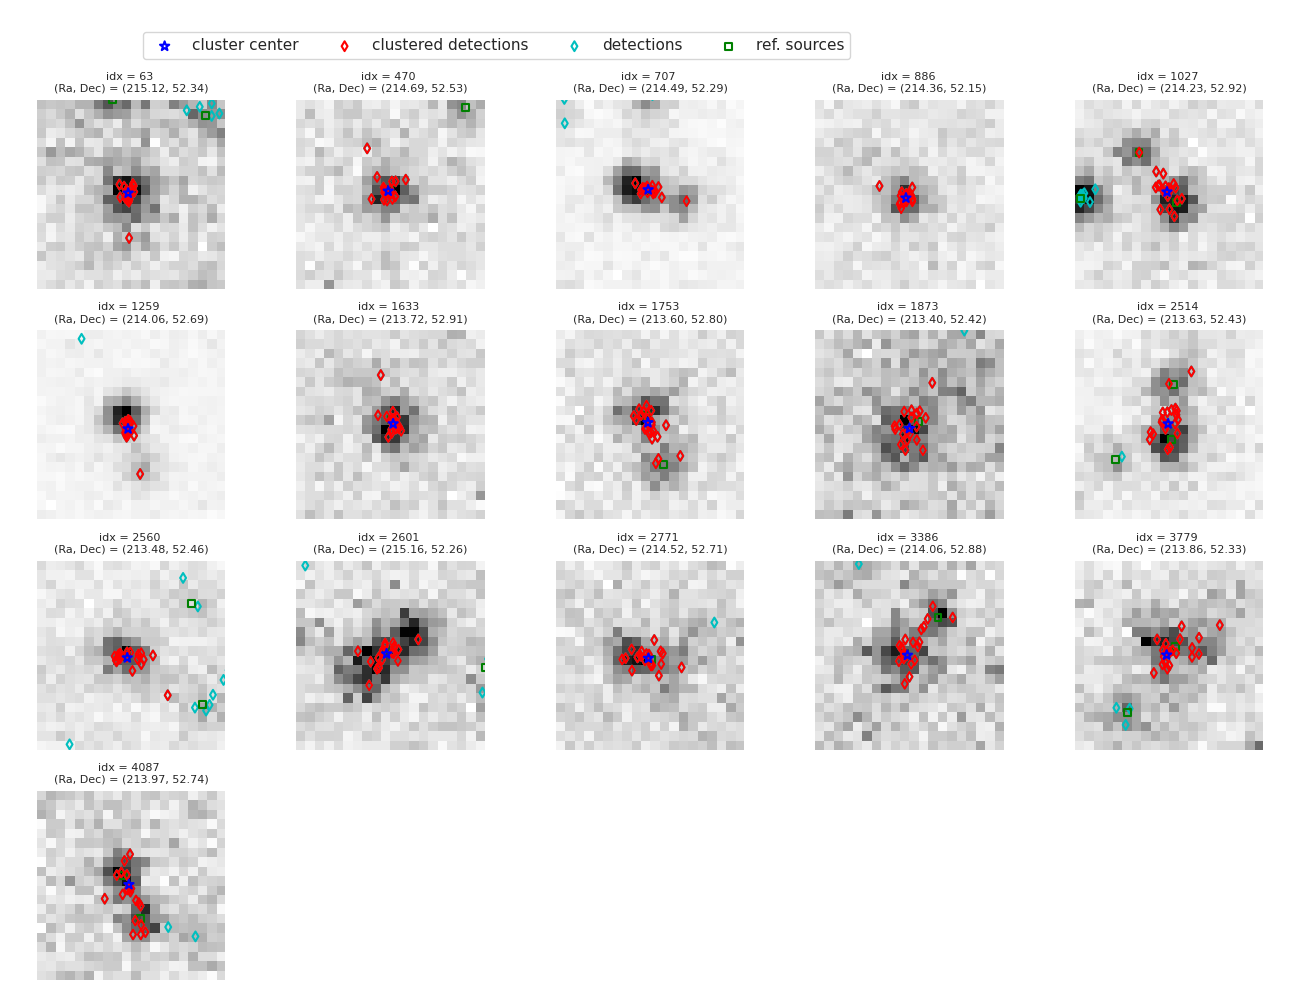

In [19]:
# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known

n_sub = len(cidxs)
ncols = 5

# Compute Rows required

nrows = np.ceil(n_sub / ncols).astype(int)
print(nrows)

# Create a Position index

sub_pos = range(1,n_sub + 1)

# Create main figure
num = 42
plt.close(num)
fig = plt.figure(num=num, figsize=(13,10))

for k, cidx  in zip(range(n_sub), cidxs):
    cpos = SkyCoord(ra=ms.cluster_centers_[cidx,0], dec=ms.cluster_centers_[cidx,1], frame="fk5", unit=uu.degree)
    ax = draw_cluster(cidx, fig=fig, nrows=nrows, ncols=ncols, sub_pos=k+1)
    
    ax.set_axis_off()
    ax.set_title(f"idx = {cidx} \n(Ra, Dec) = ({ms.cluster_centers_[cidx,0]:1.2f}, {ms.cluster_centers_[cidx,1]:1.2f})", fontsize=8)
    
    if k == 0:
        ax.legend(bbox_to_anchor=(4.35, 1.4), ncol=4)

plt.subplots_adjust(left=0.01, bottom=0.02, right=0.99, top=0.90, wspace=0.1, hspace=0.22)

<WCSAxesSubplot:xlabel='Ra', ylabel='Dec'>

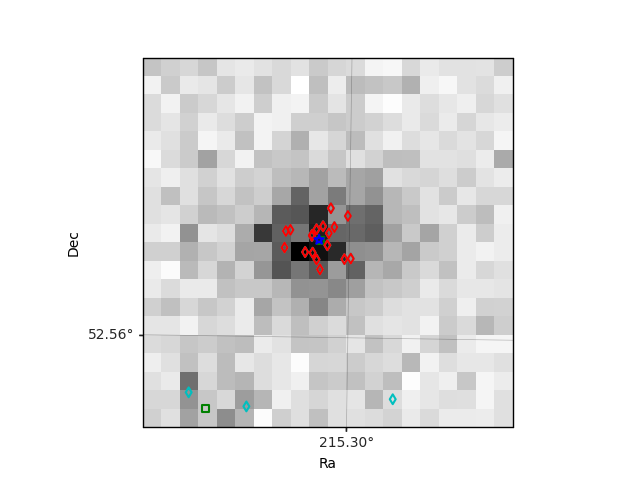

In [20]:
num=11
plt.close(num)
fig = plt.figure(num)
draw_cluster(0, fig=fig)

<WCSAxesSubplot:xlabel='Ra', ylabel='Dec'>

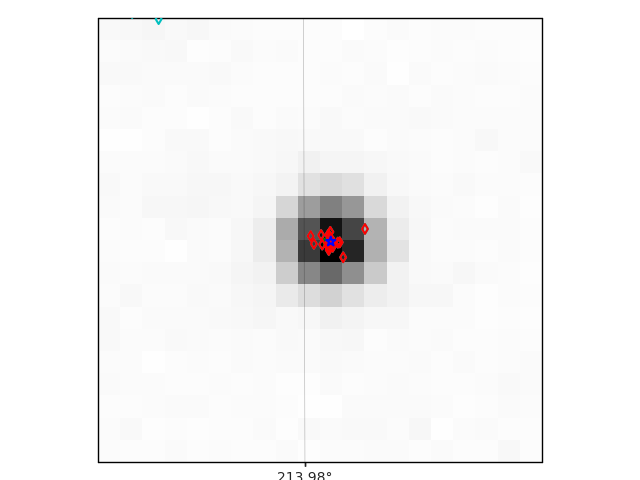

In [21]:
draw_cluster(1350)

Statistis	1D	2D
Centroid x 	9.45 	9.45
Centroid y 	9.67 	9.67
StdDev x 	4.48 	4.48
StdDev y 	4.45 	4.45
Skewness x 	-0.00 	-0.00
Skewness y 	-0.10 	-0.10
Kurtosis x 	2.71 	2.71
Kurtosis y 	2.72 	2.72


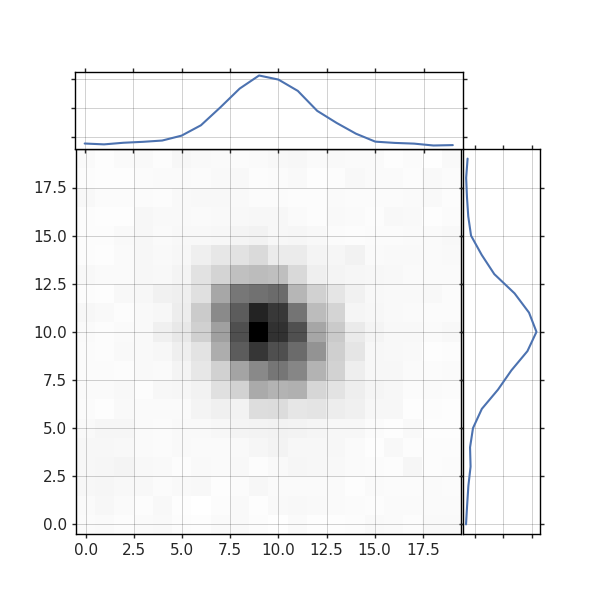

In [22]:
def image_statistics(Z):
    #Input: Z, a 2D array, hopefully containing some sort of peak
    #Output: cx,cy,sx,sy,skx,sky,kx,ky
    #cx and cy are the coordinates of the centroid
    #sx and sy are the stardard deviation in the x and y directions
    #skx and sky are the skewness in the x and y directions
    #kx and ky are the Kurtosis in the x and y directions
    #Note: this is not the excess kurtosis. For a normal distribution
    #you expect the kurtosis will be 3.0. Just subtract 3 to get the
    #excess kurtosis.
    import numpy as np

    h,w = np.shape(Z)

    x = range(w)
    y = range(h)


    #calculate projections along the x and y axes
    yp = np.sum(Z,axis=1)
    xp = np.sum(Z,axis=0)

    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)

    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2

    sx = np.sqrt( np.sum(x2*xp)/np.sum(xp) )
    sy = np.sqrt( np.sum(y2*yp)/np.sum(yp) )

    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3

    skx = np.sum(xp*x3)/(np.sum(xp) * sx**3)
    sky = np.sum(yp*y3)/(np.sum(yp) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    kx = np.sum(xp*x4)/(np.sum(xp) * sx**4)
    ky = np.sum(yp*y4)/(np.sum(yp) * sy**4)


    return cx,cy,sx,sy,skx,sky,kx,ky

#We can check that the result is the same if we use the full 2D data array
def image_statistics_2D(Z):
    h,w = np.shape(Z)

    x = range(w)
    y = range(h)

    X,Y = np.meshgrid(x,y)

    #Centroid (mean)
    cx = np.sum(Z*X)/np.sum(Z)
    cy = np.sum(Z*Y)/np.sum(Z)

    ###Standard deviation
    x2 = (range(w) - cx)**2
    y2 = (range(h) - cy)**2

    X2,Y2 = np.meshgrid(x2,y2)

    #Find the variance
    vx = np.sum(Z*X2)/np.sum(Z)
    vy = np.sum(Z*Y2)/np.sum(Z)

    #SD is the sqrt of the variance
    sx,sy = np.sqrt(vx),np.sqrt(vy)

    ###Skewness
    x3 = (range(w) - cx)**3
    y3 = (range(h) - cy)**3

    X3,Y3 = np.meshgrid(x3,y3)

    #Find the thid central moment
    m3x = np.sum(Z*X3)/np.sum(Z)
    m3y = np.sum(Z*Y3)/np.sum(Z)

    #Skewness is the third central moment divided by SD cubed
    skx = m3x/sx**3
    sky = m3y/sy**3

    ###Kurtosis
    x4 = (range(w) - cx)**4
    y4 = (range(h) - cy)**4

    X4,Y4 = np.meshgrid(x4,y4)

    #Find the fourth central moment
    m4x = np.sum(Z*X4)/np.sum(Z)
    m4y = np.sum(Z*Y4)/np.sum(Z)

    #Kurtosis is the fourth central moment divided by SD to the fourth power
    kx = m4x/sx**4
    ky = m4y/sy**4

    return cx,cy,sx,sy,skx,sky,kx,ky

Z = get_cluster_cutout(c=165).data

#Calculate the image statistics using the projection method
stats_pr = image_statistics(Z)

#Confirm that they are the same by using a 2D calculation
stats_2d = image_statistics_2D(Z)

names = ('Centroid x','Centroid y','StdDev x','StdDev y','Skewness x','Skewness y','Kurtosis x','Kurtosis y')

print('Statistis\t1D\t2D')
for name,i1,i2 in zip(names, stats_2d,stats_pr):
    print('%s \t%.2f \t%.2f'%(name, i1,i2))

img=Z
num=100
plt.close(num)
fig=plt.figure(figsize=(6, 6), num=num)
t = np.arange(img.shape[0])
f = np.arange(img.shape[1])
flim = (f.min(), f.max())
tlim = (t.min(), t.max())


gs = gridspec.GridSpec(2, 2, width_ratios=[5,1], height_ratios=[1,5])
gs.update(hspace=0, wspace=0)
ax = fig.add_subplot(gs[1,0])
axl = fig.add_subplot(gs[1,1], sharey=ax)
axb = fig.add_subplot(gs[0,0], sharex=ax)

plt.setp(axl.get_yticklabels(), visible=False)
plt.setp(axb.get_xticklabels(), visible=False)
plt.setp(axl.get_xticklabels(), visible=False)
plt.setp(axb.get_yticklabels(), visible=False)

ax.imshow(img, origin='lower',aspect='equal', cmap="Greys")

axl.plot(img.mean(1)/img.max(), f)
axb.plot(t, img.mean(0)/img.max())